In [58]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History
import netron

In [2]:
def padd_audio(audio, max_duration=5, sample_rate=16000):
    """This function take an audio and padd that audio with zeros"""
    
    max_length = max_duration * sample_rate
    padding_needed = max_length - len(audio)
    pad_left = padding_needed // 2
    pad_right = padding_needed - pad_left
    
    return np.pad(audio, (pad_left, pad_right), 'constant')

In [3]:
def mix_audio(original_audio_path, noise_audio_path, sample_rate=16000):
    """This function take an original audio path and noise audio path and mix it together"""
    
    # Load the original audio
    original_audio, sr = librosa.load(original_audio_path, sr=sample_rate)
    
    #Padd original audio
    original_audio = padd_audio(original_audio, sample_rate=sample_rate)
    
    # Load the noise audio
    noise_audio, sr_noise = librosa.load(noise_audio_path, sr=sample_rate)
    
    # Repeat the noise audio
    noise_audio = np.tile(noise_audio, int(np.ceil(len(original_audio) / len(noise_audio))))

    # Trim the repeated noise audio to match the length of the original audio
    noise_audio = noise_audio[:len(original_audio)]
    
    return original_audio + noise_audio/2

In [4]:
def get_clean_audio(original_audio_path, sample_rate=16000):
    """This function take an original audio path and return padded audio"""
    
    # Load the original audio
    original_audio, sr = librosa.load(original_audio_path, sr=sample_rate)
    
    #Padd original audio
    return padd_audio(original_audio, sample_rate=sample_rate)

In [5]:
sr = 16000  # Sampling rate   

In [6]:
# Randmly chosen noise for each audio
def combine_audio_with_noise(original_audio_dir, noise_audio_dir):
    combination_dict = {}
    noise_audios = os.listdir(noise_audio_dir)
    original_audios = os.listdir(original_audio_dir)
    
    for original_audio in original_audios:
        noise_audio = np.random.choice(noise_audios)
        combination_dict[os.path.join(original_audio_dir, original_audio)] = os.path.join(noise_audio_dir, noise_audio)
        
    return combination_dict

In [7]:
def audio_to_stft(audio, n_fft=1199, hop_length_fft=304):
    # STFT transformation
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)

    # Extract magnitude and phase
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    # Convert magnitude to dB
    stftaudio_magnitude_db = librosa.amplitude_to_db(stftaudio_magnitude, ref=np.max)
    
    return stftaudio_magnitude_db, stftaudio_phase

In [8]:
def stft_to_audio(stftaudio_magnitude_db, stftaudio_phase, hop_length_fft=304):
# Convert dB back to amplitude
    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # Reconstruct the STFT complex matrix
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase

    # Inverse STFT to get back the audio signal
    audio_reconstruct = librosa.istft(audio_reverse_stft, hop_length=hop_length_fft)

    return audio_reconstruct / np.max(np.abs(audio_reconstruct))

In [9]:
# Example of normalization function using global min and max values
def normalize(stft, global_min, global_max):
    return (stft - global_min) / (global_max - global_min)

# Example of denormalization function using global min and max values
def denormalize(normalized_stft, global_min, global_max):
    return normalized_stft * (global_max - global_min) + global_min

In [ ]:
def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_'+string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_'+string])
        plt.title(string+' through epochs')
        plt.show()

In [ ]:
def get_audio_predictions(output_prediction, phase, global_min=global_min, global_max=global_max):
    prediction = denormalize(output_prediction.squeeze(), global_min, global_max)
    audio_prediction = stft_to_audio(prediction, phase, hop_length_fft=304)
    return audio_prediction

# Preprocessing the data

In [10]:
audio_noise_pairs = combine_audio_with_noise(os.path.join(os.getcwd(), 'Dataset'), os.path.join(os.getcwd(), 'Noise'))

#Getting all the noisy and clean audio matrices
noisy_audios = np.zeros(len(audio_noise_pairs), dtype=object)
clean_audios = np.zeros(len(audio_noise_pairs), dtype=object)

for index, (audio_dir, noise_dir) in enumerate(audio_noise_pairs.items()):
    noisy_audios[index] = mix_audio(audio_dir, noise_dir, sample_rate=16000)
    clean_audios[index] = get_clean_audio(audio_dir, sample_rate=16000)

In [11]:
#Getting STFT data for learning process
noisy_audios_stft = [audio_to_stft(audio)[0] for audio in noisy_audios]
noisy_audios_stft_phase = [audio_to_stft(audio)[1] for audio in noisy_audios]
clean_audios_stft = [audio_to_stft(audio)[0] for audio in clean_audios]

In [12]:
#Splitting the data for training 80%, validation 10% and test set 10%
split_ratio1 = 0.8
split_ratio2 = 0.9
split_index1 = int(len(noisy_audios_stft) * split_ratio1)
split_index2 = int(len(noisy_audios_stft) * split_ratio2)

X_train = noisy_audios_stft[:split_index1]
X_val = noisy_audios_stft[split_index1:split_index2]
X_test = noisy_audios_stft[split_index2:]

y_train = clean_audios_stft[:split_index1]
y_val = clean_audios_stft[split_index1:split_index2]
y_test = clean_audios_stft[split_index2:]

phase_train = noisy_audios_stft_phase[:split_index1]
phase_val = noisy_audios_stft_phase[split_index1:split_index2]
phase_test = noisy_audios_stft_phase[split_index2:]

In [13]:
# Find the global min and max values from both the noisy and clean STFT data
global_min = min(np.min(X_train), np.min(y_train))
global_max = max(np.max(X_train), np.max(y_train))

In [14]:
#Normalize data based on the data from training set
X_train_normalized = normalize(X_train, global_min, global_max)
X_val_normalized = normalize(X_val, global_min, global_max)
X_test_normalized = normalize(X_test, global_min, global_max)

y_train_normalized = normalize(y_train, global_min, global_max)
y_val_normalized = normalize(y_val, global_min, global_max)
y_test_normalized = normalize(y_test, global_min, global_max)

In [15]:
#Transform data to tensors: sample x dimensions(n x n) x channel(1)
X_train_normalized = X_train_normalized[..., np.newaxis]
X_val_normalized = X_val_normalized[..., np.newaxis]
X_test_normalized = X_test_normalized[..., np.newaxis]

y_train_normalized = y_train_normalized[..., np.newaxis]
y_val_normalized = y_val_normalized[..., np.newaxis]
y_test_normalized = y_test_normalized[..., np.newaxis]

# Model

In [51]:
def generator(X, y, batch_size=16, epochs=100):
    assert len(X) == len(y), "The length of X and y must be the same"
    
    # Iterate through each epoch
    for epoch in range(epochs):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_X = X_shuffled[start:end]
            batch_y = y_shuffled[start:end]
            
            yield batch_X, batch_y

In [54]:
# Encoder
def encoder(inputs):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    encoded = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    return encoded

# Decoder
def decoder(encoded):
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Single channel output
    return decoded

In [55]:
#Batch size
batch_size = 16

# Input shape
input_shape = (600, 264, 1)
inputs = Input(shape=input_shape)

# Build the autoencoder
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = Model(inputs, decoded)

# Optimizer adapts learning rate based on batch size, using Adam optimizer
optimizer = Adam(learning_rate=0.01*(batch_size/256), beta_1=0.9, beta_2=0.999)

autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the model
autoencoder.summary()

# Initialize model checkpointing to save the model with the lowest loss.
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Set up early stopping to halt training if loss doesn't improve after 20 epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min', verbose=1)

# Configure learning rate reduction if loss doesn't improve after 3 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0000001)

# Fit the model
history = autoencoder.fit(generator(X_train_normalized, y_train_normalized),
                          steps_per_epoch=len(X_train_normalized) // batch_size,
                          epochs=100,
                          validation_data=(X_val_normalized, y_val_normalized),
                          callbacks=[model_checkpoint, early_stopping, reduce_lr])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 600, 264, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 600, 264, 64)      640       
                                                                 
 batch_normalization_18 (Bat  (None, 600, 264, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 300, 132, 64)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 300, 132, 128)     73856     
                                                                 
 batch_normalization_19 (Bat  (None, 300, 132, 128)    512 

# Results

In [47]:
#Network visualization
netron.start('best_model.h5')

Serving 'best_model.h5' at http://localhost:8080


('localhost', 8080)

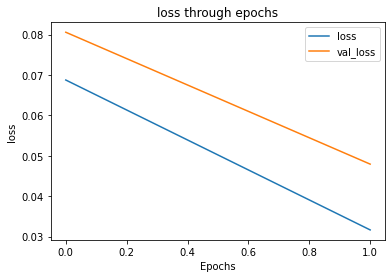

In [56]:
plot_graphs(history, 'loss')

In [61]:
#Train loss
train_loss = autoencoder.evaluate(X_train_normalized, y_train_normalized, verbose=1)

#Validation loss
val_loss = autoencoder.evaluate(X_val_normalized, y_val_normalized, verbose=1)

#Test loss
test_loss = autoencoder.evaluate(X_test_normalized, y_test_normalized, verbose=1)

results = pd.DataFrame([[train_loss, val_loss, test_loss]],
            columns = ['train', 'validation', 'test'])
results

3/3 [==============================] - 21s 6s/step - loss: 0.0491


,train,validation,test
0,0.045805,0.047926,0.049091


# Predictions

In [22]:
autoencoder=load_model('best_model.h5')

In [28]:
predictions = autoencoder.predict(X_test_normalized)

3/3 [==============================] - 11s 3s/step


In [29]:
audio_pred = get_audio_predictions(predictions[2], phase_test[2])

In [30]:
sf.write('audio_pred.wav', audio_pred, samplerate=sr)

In [31]:
sf.write('audio_noisy.wav', stft_to_audio(X_test[2], phase_test[2], hop_length_fft=304), samplerate=sr)